# Otimização de Arquitetura de Redes Neurais com Algoritmos Genéticos 

## Teste 02: Dataset CIFAR-10

### 01. Importação de Bibliotecas

In [1]:
# Importação de Bibliotecas
import time
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, random_split
from deap import base, creator, tools, algorithms
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

### 02. Separação do Dataset

In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# Dividindo o trainset em treino e validação
val_size = int(0.1 * len(trainset))
train_size = len(trainset) - val_size
trainset, validset = random_split(trainset, [train_size, val_size])

trainloader = DataLoader(trainset, batch_size=64, shuffle=True)
validloader = DataLoader(validset, batch_size=64, shuffle=False)
testloader = DataLoader(testset, batch_size=100, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


### 03. Arquitetura inicial da Rede Neural

In [3]:
# Definindo a arquitetura da rede neural
class SimpleNet(nn.Module):
    def __init__(self, n_neurons, activation_fn):
        super(SimpleNet, self).__init__()
        self.fc1 = nn.Linear(32 * 32 * 3, n_neurons)  # CIFAR-10 tem 32x32x3 pixels
        self.activation = activation_fn
        self.fc2 = nn.Linear(n_neurons, 10)  # CIFAR-10 tem 10 classes

    def forward(self, x):
        x = x.view(-1, 32 * 32 * 3)
        x = self.fc1(x)
        x = self.activation(x)
        x = self.fc2(x)
        return x

### 04. Função de treinamento e avaliação do Modelo

In [4]:
# Função de treinamento e avaliação
def train_and_evaluate(model, trainloader, testloader, criterion, optimizer, num_epochs=10):
    start_time = time.time()
    train_losses = []
    
    for epoch in tqdm(range(num_epochs), desc='Treinamento', unit='época'):
        running_loss = 0.0
        for inputs, labels in tqdm(trainloader, desc='Batchs', leave=False, unit='batch'):
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        avg_loss = running_loss / len(trainloader)
        train_losses.append(avg_loss)
        print(f"Época {epoch + 1}, Loss: {avg_loss:.4f}")
    
    total = 0
    correct = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in tqdm(testloader, desc='Avaliação', unit='batch'):
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    accuracy = correct / total
    time_taken = time.time() - start_time
    cm = confusion_matrix(all_labels, all_preds)
    return accuracy, train_losses, time_taken, cm

### 05. Algoritmo Genético

In [5]:
# Função de avaliação do indivíduo
def evaluate_individual(individual):
    n_neurons, activation_idx, learning_rate, batch_size = individual

    # Certifique-se de que activation_idx esteja dentro do intervalo esperado
    activation_idx = min(max(activation_idx, 0), 1)
    activation_fn = [nn.ReLU(), nn.Sigmoid()][activation_idx]
    
    model = SimpleNet(n_neurons, activation_fn)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=learning_rate)

    # Treinamento no conjunto de treinamento
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
    for epoch in range(3):  # Treinando por 3 épocas como exemplo
        for inputs, labels in trainloader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

    # Avaliação no conjunto de validação
    validloader = torch.utils.data.DataLoader(validset, batch_size=batch_size, shuffle=False)
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in validloader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = correct / total
    return accuracy,

In [6]:
# Configuração do Algoritmo Genético
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

toolbox = base.Toolbox()
toolbox.register("attr_int", random.randint, 10, 200)  # Número de neurônios
toolbox.register("attr_activation", random.randint, 0, 1)  # Função de ativação (ReLU ou Sigmoid)
toolbox.register("attr_float", random.uniform, 0.001, 0.1)  # Taxa de aprendizado
toolbox.register("attr_batch", random.randint, 32, 128)  # Tamanho do batch

toolbox.register("individual", tools.initCycle, creator.Individual, 
                 (toolbox.attr_int, toolbox.attr_activation, toolbox.attr_float, toolbox.attr_batch), n=1)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("evaluate", evaluate_individual)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutUniformInt, low=10, up=200, indpb=0.2)
toolbox.register("select", tools.selTournament, tournsize=3)

# Algoritmo Genético
population = toolbox.population(n=10)
NGEN = 5
for gen in tqdm(range(NGEN), desc='Gerações'):
    offspring = algorithms.varAnd(population, toolbox, cxpb=0.5, mutpb=0.2)
    
    fits = list(tqdm(map(toolbox.evaluate, offspring), total=len(offspring), desc="Avaliando Indivíduos"))
    
    for fit, ind in zip(fits, offspring):
        ind.fitness.values = fit
    population = toolbox.select(offspring, k=len(population))

# Seleciona o melhor indivíduo
top_ind = tools.selBest(population, k=1)[0]

# Parâmetros do melhor indivíduo
best_params = {
    'n_neurons': top_ind[0],
    'activation_idx': top_ind[1],
    'learning_rate': top_ind[2],
    'batch_size': top_ind[3]
}

Gerações: 100%|██████████████████████████████████████████████████████████████████████████| 5/5 [40:47<00:00, 489.42s/it]


In [7]:
print("Melhor indivíduo:", top_ind)
print("Parâmetros:", best_params)

Melhor indivíduo: [72, 0, 0.06483102223312642, 62]
Parâmetros: {'n_neurons': 72, 'activation_idx': 0, 'learning_rate': 0.06483102223312642, 'batch_size': 62}


### 06. Treinamento dos Modelos

#### Modelo Não Otimizado 1

In [9]:
# Modelo Não Otimizado
model_non_opt_1 = SimpleNet(n_neurons=50, activation_fn=nn.Sigmoid())
criterion_1 = nn.CrossEntropyLoss()
optimizer_1 = optim.SGD(model_non_opt_1.parameters(), lr=0.01)

accuracy_non_opt_1, train_losses_non_opt_1, time_non_opt_1, cm_non_opt_1 = train_and_evaluate(model_non_opt_1, trainloader, testloader, criterion_1, optimizer_1)

Treinamento:  10%|██████▊                                                             | 1/10 [00:17<02:33, 17.03s/época]

Época 1, Loss: 2.1339



Treinamento:  20%|█████████████▌                                                      | 2/10 [00:32<02:09, 16.17s/época]

Época 2, Loss: 1.9758



Treinamento:  30%|████████████████████▍                                               | 3/10 [00:48<01:52, 16.13s/época]

Época 3, Loss: 1.9025



Treinamento:  40%|███████████████████████████▏                                        | 4/10 [01:04<01:35, 15.91s/época]

Época 4, Loss: 1.8595



Treinamento:  50%|██████████████████████████████████                                  | 5/10 [01:20<01:19, 15.90s/época]

Época 5, Loss: 1.8290



Treinamento:  60%|████████████████████████████████████████▊                           | 6/10 [01:35<01:03, 15.87s/época]

Época 6, Loss: 1.8040



Treinamento:  70%|███████████████████████████████████████████████▌                    | 7/10 [01:51<00:47, 15.84s/época]

Época 7, Loss: 1.7848



Treinamento:  80%|██████████████████████████████████████████████████████▍             | 8/10 [02:07<00:31, 15.73s/época]

Época 8, Loss: 1.7666



Treinamento:  90%|█████████████████████████████████████████████████████████████▏      | 9/10 [02:23<00:15, 15.76s/época]

Época 9, Loss: 1.7521



Treinamento: 100%|███████████████████████████████████████████████████████████████████| 10/10 [02:39<00:00, 15.92s/época]


Época 10, Loss: 1.7385


Avaliação: 100%|███████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 30.32batch/s]


#### Modelo Não Otimizado 2

In [11]:
# Modelo Não Otimizado
model_non_opt_2 = SimpleNet(n_neurons=200, activation_fn=nn.ReLU())
criterion_2 = nn.CrossEntropyLoss()
optimizer_2 = optim.SGD(model_non_opt_2.parameters(), lr=0.05)

accuracy_non_opt_2, train_losses_non_opt_2, time_non_opt_2, cm_non_opt_2 = train_and_evaluate(model_non_opt_2, trainloader, testloader, criterion_2, optimizer_2)

Treinamento:  10%|██████▊                                                             | 1/10 [00:20<03:06, 20.73s/época]

Época 1, Loss: 1.7013



Treinamento:  20%|█████████████▌                                                      | 2/10 [00:39<02:35, 19.50s/época]

Época 2, Loss: 1.5020



Treinamento:  30%|████████████████████▍                                               | 3/10 [00:58<02:13, 19.14s/época]

Época 3, Loss: 1.4113



Treinamento:  40%|███████████████████████████▏                                        | 4/10 [01:16<01:52, 18.82s/época]

Época 4, Loss: 1.3447



Treinamento:  50%|██████████████████████████████████                                  | 5/10 [01:34<01:31, 18.38s/época]

Época 5, Loss: 1.2866



Treinamento:  60%|████████████████████████████████████████▊                           | 6/10 [01:51<01:12, 18.21s/época]

Época 6, Loss: 1.2363



Treinamento:  70%|███████████████████████████████████████████████▌                    | 7/10 [02:09<00:54, 18.02s/época]

Época 7, Loss: 1.1958



Treinamento:  80%|██████████████████████████████████████████████████████▍             | 8/10 [02:27<00:35, 17.97s/época]

Época 8, Loss: 1.1579



Treinamento:  90%|█████████████████████████████████████████████████████████████▏      | 9/10 [02:45<00:17, 17.96s/época]

Época 9, Loss: 1.1204



Treinamento: 100%|███████████████████████████████████████████████████████████████████| 10/10 [03:03<00:00, 18.35s/época]


Época 10, Loss: 1.0866


Avaliação: 100%|███████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 32.73batch/s]


#### Modelo Não Otimizado 3

In [12]:
# Modelo Não Otimizado
model_non_opt_3 = SimpleNet(n_neurons=100, activation_fn=nn.ReLU())
criterion_3 = nn.CrossEntropyLoss()
optimizer_3 = optim.SGD(model_non_opt_3.parameters(), lr=0.01)

accuracy_non_opt_3, train_losses_non_opt_3, time_non_opt_3, cm_non_opt_3 = train_and_evaluate(model_non_opt_3, trainloader, testloader, criterion_3, optimizer_3)

Treinamento:  10%|██████▊                                                             | 1/10 [00:17<02:36, 17.41s/época]

Época 1, Loss: 1.9051



Treinamento:  20%|█████████████▌                                                      | 2/10 [00:33<02:14, 16.85s/época]

Época 2, Loss: 1.6908



Treinamento:  30%|████████████████████▍                                               | 3/10 [00:50<01:58, 16.92s/época]

Época 3, Loss: 1.6091



Treinamento:  40%|███████████████████████████▏                                        | 4/10 [01:08<01:42, 17.15s/época]

Época 4, Loss: 1.5565



Treinamento:  50%|██████████████████████████████████                                  | 5/10 [01:25<01:26, 17.21s/época]

Época 5, Loss: 1.5149



Treinamento:  60%|████████████████████████████████████████▊                           | 6/10 [01:43<01:09, 17.27s/época]

Época 6, Loss: 1.4817



Treinamento:  70%|███████████████████████████████████████████████▌                    | 7/10 [01:59<00:51, 17.01s/época]

Época 7, Loss: 1.4504



Treinamento:  80%|██████████████████████████████████████████████████████▍             | 8/10 [02:16<00:33, 16.87s/época]

Época 8, Loss: 1.4221



Treinamento:  90%|█████████████████████████████████████████████████████████████▏      | 9/10 [02:32<00:16, 16.72s/época]

Época 9, Loss: 1.3962



Treinamento: 100%|███████████████████████████████████████████████████████████████████| 10/10 [02:48<00:00, 16.89s/época]


Época 10, Loss: 1.3725


Avaliação: 100%|███████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 34.13batch/s]


#### Modelo Otimizado

In [13]:
# Modelo Otimizado
activation_fn = [nn.ReLU(), nn.Sigmoid()][best_params['activation_idx']]
model_opt = SimpleNet(best_params['n_neurons'], activation_fn)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_opt.parameters(), lr=best_params['learning_rate'])

accuracy_opt, train_losses_opt, time_opt, cm_opt = train_and_evaluate(model_opt, trainloader, testloader, criterion, optimizer)

Treinamento:  10%|██████▊                                                             | 1/10 [00:17<02:35, 17.23s/época]

Época 1, Loss: 1.7005



Treinamento:  20%|█████████████▌                                                      | 2/10 [00:33<02:11, 16.38s/época]

Época 2, Loss: 1.5214



Treinamento:  30%|████████████████████▍                                               | 3/10 [00:48<01:52, 16.05s/época]

Época 3, Loss: 1.4414



Treinamento:  40%|███████████████████████████▏                                        | 4/10 [01:04<01:35, 15.94s/época]

Época 4, Loss: 1.3858



Treinamento:  50%|██████████████████████████████████                                  | 5/10 [01:20<01:19, 15.87s/época]

Época 5, Loss: 1.3451



Treinamento:  60%|████████████████████████████████████████▊                           | 6/10 [01:36<01:03, 15.87s/época]

Época 6, Loss: 1.3071



Treinamento:  70%|███████████████████████████████████████████████▌                    | 7/10 [01:51<00:47, 15.85s/época]

Época 7, Loss: 1.2757



Treinamento:  80%|██████████████████████████████████████████████████████▍             | 8/10 [02:07<00:31, 15.81s/época]

Época 8, Loss: 1.2494



Treinamento:  90%|█████████████████████████████████████████████████████████████▏      | 9/10 [02:23<00:15, 15.85s/época]

Época 9, Loss: 1.2280



Treinamento: 100%|███████████████████████████████████████████████████████████████████| 10/10 [02:41<00:00, 16.12s/época]


Época 10, Loss: 1.2085


Avaliação: 100%|███████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 33.49batch/s]


### 07. Avaliação dos Modelos

In [14]:
# Comparação dos Resultados
print(f"Modelo Não Otimizado 1: Acurácia = {accuracy_non_opt_1:.4f}, Loss = {train_losses_non_opt_1[-1]:.4f}, Tempo = {time_non_opt_1:.2f}s")
print(f"Modelo Não Otimizado 2: Acurácia = {accuracy_non_opt_2:.4f}, Loss = {train_losses_non_opt_2[-1]:.4f}, Tempo = {time_non_opt_2:.2f}s")
print(f"Modelo Não Otimizado 3: Acurácia = {accuracy_non_opt_3:.4f}, Loss = {train_losses_non_opt_3[-1]:.4f}, Tempo = {time_non_opt_3:.2f}s")
print(f"Modelo Otimizado: Acurácia = {accuracy_opt:.4f}, Loss = {train_losses_opt[-1]:.4f}, Tempo = {time_opt:.2f}s")

Modelo Não Otimizado 1: Acurácia = 0.3972, Loss = 1.7385, Tempo = 162.50s
Modelo Não Otimizado 2: Acurácia = 0.4848, Loss = 1.0866, Tempo = 186.57s
Modelo Não Otimizado 3: Acurácia = 0.4960, Loss = 1.3725, Tempo = 171.88s
Modelo Otimizado: Acurácia = 0.4421, Loss = 1.2085, Tempo = 164.18s


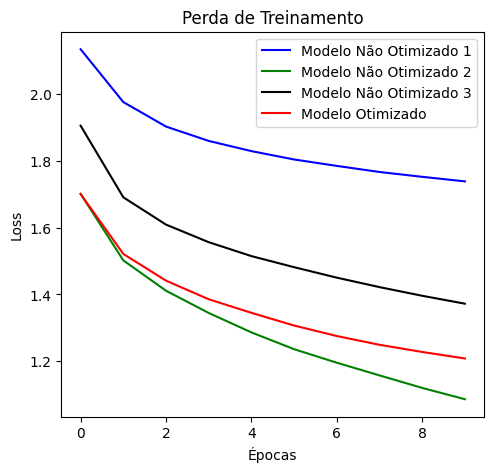

In [15]:
# Plotando gráficos comparativos
plt.figure(figsize=(12, 5))

# Gráfico da perda de treinamento
plt.subplot(1, 2, 1)
plt.plot(train_losses_non_opt_1, label='Modelo Não Otimizado 1', color='blue')
plt.plot(train_losses_non_opt_2, label='Modelo Não Otimizado 2', color='green')
plt.plot(train_losses_non_opt_3, label='Modelo Não Otimizado 3', color='black')
plt.plot(train_losses_opt, label='Modelo Otimizado', color='red')
plt.xlabel('Épocas')
plt.ylabel('Loss')
plt.title('Perda de Treinamento')
plt.legend()

In [ ]:
# Gráfico de comparação de acurácia e tempo de treinamento
plt.subplot(1, 2, 2)
bar_width = 0.35
index = range(2)
bar1 = plt.bar(index, [accuracy_non_opt, accuracy_opt], bar_width, label='Acurácia')
bar2 = plt.bar([i + bar_width for i in index], [time_non_opt, time_opt], bar_width, label='Tempo (s)')
plt.xlabel('Modelo')
plt.ylabel('Valor')
plt.title('Comparação de Modelos')
plt.xticks([i + bar_width / 2 for i in index], ['Não Otimizado', 'Otimizado'])
plt.legend()

plt.tight_layout()
plt.show()

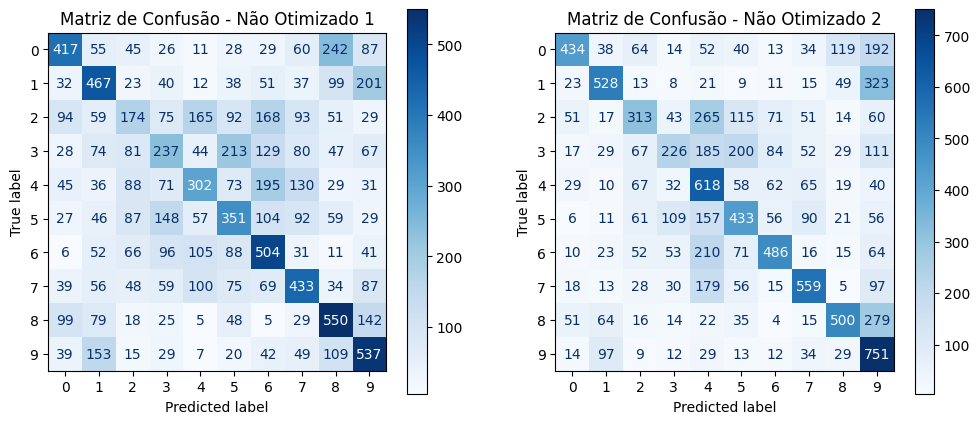

In [17]:
# Plotando a Matriz de Confusão
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Matriz de Confusão - Modelo Não Otimizado 1
disp_non_opt_1 = ConfusionMatrixDisplay(confusion_matrix=cm_non_opt_1, display_labels=range(10))
disp_non_opt_1.plot(ax=ax[0], cmap=plt.cm.Blues, values_format='d')
ax[0].set_title('Matriz de Confusão - Não Otimizado 1')

# Matriz de Confusão - Modelo Não Otimizado 2
disp_non_opt_2 = ConfusionMatrixDisplay(confusion_matrix=cm_non_opt_2, display_labels=range(10))
disp_non_opt_2.plot(ax=ax[1], cmap=plt.cm.Blues, values_format='d')
ax[1].set_title('Matriz de Confusão - Não Otimizado 2')

plt.show()

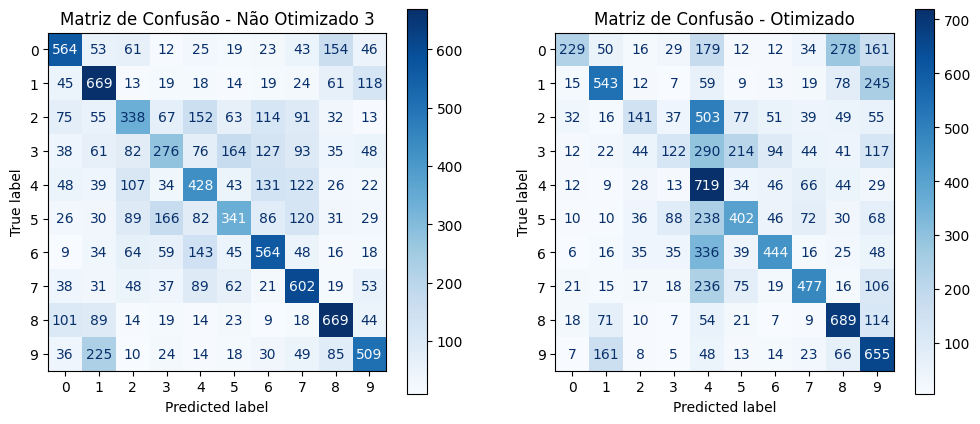

In [18]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Matriz de Confusão - Modelo Não Otimizado 3
disp_non_opt_3 = ConfusionMatrixDisplay(confusion_matrix=cm_non_opt_3, display_labels=range(10))
disp_non_opt_3.plot(ax=ax[0], cmap=plt.cm.Blues, values_format='d')
ax[0].set_title('Matriz de Confusão - Não Otimizado 3')

# Matriz de Confusão - Modelo Otimizado
disp_opt = ConfusionMatrixDisplay(confusion_matrix=cm_opt, display_labels=range(10))
disp_opt.plot(ax=ax[1], cmap=plt.cm.Blues, values_format='d')
ax[1].set_title('Matriz de Confusão - Otimizado')

plt.show()